# Classification of data with Support Vector Machines (SVM) 

Datasets distributed in a two-dimensional parameter (feature) space are classified according to quantifiable characteristics of each data point such that data points assigned to a certain class exhibit the same characteristics (properties).

Author: Alexander Hartmaier</br>
Institution: ICAMS, Ruhr-Universität Bochum, Germany</br>
Date: March 2021

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

## 1. Maximum margin separating hyperplane

Plot the maximum margin separating hyperplane within a two-class
separable dataset using a Support Vector Machine classifier with
linear kernel. Example adapted from the scikit-learn platform, see https://scikit-learn.org/stable/


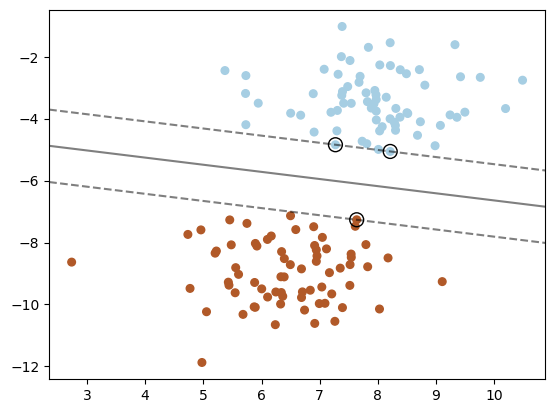

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=140, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=100)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

## 2. Classification of elastic and plastic stresses

Assume a sheet material that is subjected to a plane-stress load, with pure normal stresses, i.e. no shear components are present. In this case, the state of stress can be described with two normal stresses $\sigma_{xx}$ and $\sigma_{yy}$ along the $x$- and $y$-axis of the sheet, respectively. To decide whether the material will undergo purely elastic or rather elastic-plastic deformation, one has to evaluate a yield function $f$ based on the equivalent stress $\sigma_{eq}$, in the form

\begin{equation} f = \sigma_{eq} - \sigma_y\,. \end{equation}

Plastic deformation sets in at $f=0$, i.e. when the the equivalent stress $\sigma_{eq}$ equals the yield strength $\sigma_y$ of the material. For smaller equivalent stresses the material behavior is purely elastic. The equivalent stress used here is based on the pricipal stresses $\sigma_i$ with $(i=1, 2, 3)$, as

\begin{equation} 
\sigma_{eq} = \sqrt{ \frac{1}{2}\left[ H_1 \left(\sigma_1-\sigma_2\right)^2 
                       + H_2 \left(\sigma_2-\sigma_3\right)^2 
                       + H_3 \left(\sigma_3-\sigma_1\right)^2   \right] } .
\end{equation}

In this simple example, we can assume that $\sigma_1 = \sigma_{xx}$, $\sigma_2 = \sigma_{yy}$, $\sigma_3 = 0$.

In the following code segment, functions are introduced to calculate the equivalent stress and to plot the stress data together with the results of the trained support vector classifier (SVC).

### Tasks:
1. Study the results of the SVC training process as you change the paramaters "C" and "gamma"
2. Change from stress data points on a fixed grid to randomized stresses and observe the results of the training process. You may also change the number of data points.

SVC(C=10.0, gamma=1.0)
Training set score: 99.5 %


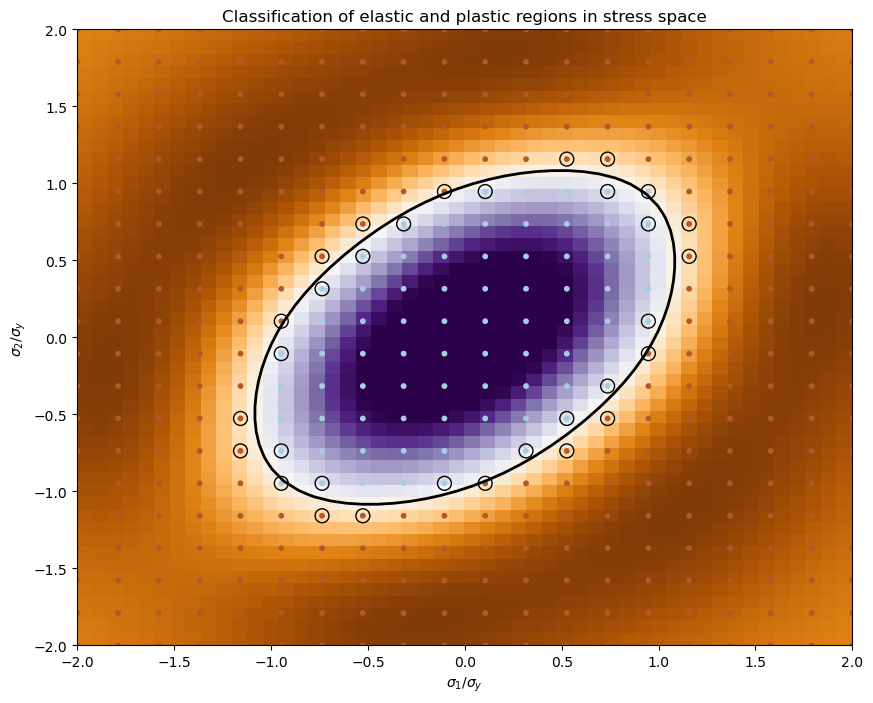

In [2]:
def seq(sig, hp=[1.,1.,1.]):
    '''Calculate J2 equivalent stress from principal stresses
    
    Parameters
    ----------
    sig : (N,3)-array
        list of principal stresses
         
    Returns
    -------
    seq : (N,)-array
        J2 equivalent stresses
    '''

    d12 = sig[:,0] - sig[:,1]
    d23 = sig[:,1] - sig[:,2]
    d31 = sig[:,2] - sig[:,0]
    J2  = 0.5*(hp[0]*np.square(d12) + hp[1]*np.square(d23) + hp[2]*np.square(d31))
    seq  = np.sqrt(J2)  # J2 eqiv. stress
    return seq

def plot_data(Z, axs, xx, yy, field=True, c='red'):
    '''Plotting data in stress space to visualize yield loci.

    Parameters
    ----------
    Z   : array
        Data for field plot
    axs : handle
        Axes where plot is added
    xx  : meshgrid
        x-coordinates
    yy  : meshgrid
        y-coordinates
    field : Boolean
        Decide if field is plotted (optional, default: True)
    c   : str
        Color for contour line (optional, default: 'red')

    Returns
    -------
    line : handle
        Reference to plotted line
    '''
    #symmetrize Z values
    zmin = np.amin(Z)
    zmax = np.amax(Z)
    if (-zmin < zmax):
        Z[np.nonzero(Z>-zmin)] = -zmin
    else:
        Z[np.nonzero(Z<-zmax)] = -zmax
    Z = Z.reshape(xx.shape)

    #display data
    if field:
        im = axs.imshow(Z, interpolation='nearest',
            extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
            origin='lower', cmap=plt.cm.PuOr_r)
    contour = axs.contour(xx, yy, Z, levels=[0], linewidths=2,
                linestyles='solid', colors=c)
    line = contour.collections
    return line

#generate stress data set for training purposes
N = 20 # number of data points per axis
rand = False # use random stresses
if rand:
    # training with random data
    sig = np.zeros((N*N, 3))
    sig[:,0:2] = np.random.rand(N*N,2)*4. - 2.
else:
    # fixed grid for training data
    x = np.linspace(-2., 2, N)
    y = np.linspace(-2., 2, N)
    sx, sy = np.meshgrid(x, y)
    sig = np.c_[sx.ravel(), sy.ravel(), np.zeros(N*N)]

# calculate yield function as result vector
sig_eq = seq(sig)
f_train = np.sign(sig_eq - 1.) # yield function for sigma_y = 1.
ind = np.nonzero(np.abs(f_train)<0.9)[0]
f_train[ind]=1. # training data should be only -1 or +1, but sign-fct also returns 0
s_train = sig[:,0:2] 

# train SVC with data set
svm_yf = svm.SVC(kernel='rbf',C=10.,gamma=1.)
svm_yf.fit(s_train, f_train)
train_sc = 100*svm_yf.score(s_train, f_train)
print(svm_yf)
print("Training set score: {} %".format(train_sc))

# evaluate and plot classification function in entire 2D stress space
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
xx, yy = np.meshgrid(np.linspace(-2., 2., 50),np.linspace(-2., 2., 50))
feat = np.c_[yy.ravel(),xx.ravel()]
Z = svm_yf.decision_function(feat)

#plot data function
plot_data(Z, ax, xx, yy, c='black')
ax.scatter(s_train[:,0], s_train[:,1], s=10, c=f_train, cmap=plt.cm.Paired)

# plot support vectors
ax.scatter(svm_yf.support_vectors_[:, 0], svm_yf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
ax.set_title('Classification of elastic and plastic regions in stress space')
ax.set_xlabel('$\sigma_1/\sigma_y$')
ax.set_ylabel('$\sigma_2/\sigma_y$')
plt.show()